Shape: (10000, 9)
                  Faculty                         Department  UTME_Score  \
0                     Law                                Law         365   
1                    Arts                            Russian         206   
2  Basic Medical Sciences         Medical Laboratory Science         201   
3             Engineering  Civil & Environmental Engineering         204   
4     Management Sciences                         Accounting         233   

   Post_UTME_Score  Aggregate  Cutoff  Olevel_Valid  olevel_avg_points  \
0               25      84.62  68.650             1               2.80   
1               10      51.75  67.650             1               3.20   
2               22      61.52  74.675             1               2.88   
3                7      46.90  50.000             1               2.88   
4               25      69.72  74.100             1               3.12   

   admitted_numeric  
0                 2  
1                 0  
2             

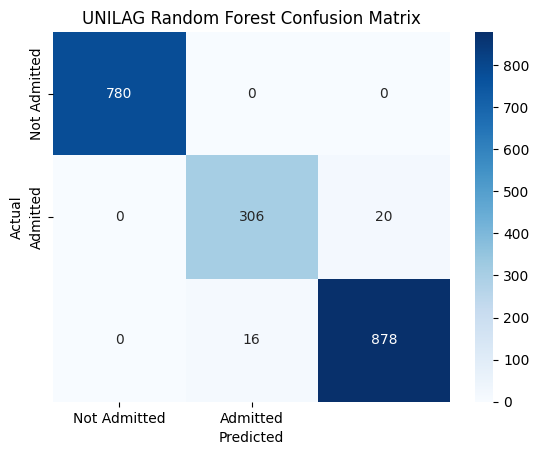

UNILAG model saved successfully at ../../Models/unilag_admission_model.pkl


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Load UNILAG processed dataset
unilag_df = pd.read_csv("../../Data/UNILAG_processed.csv")
print("Shape:", unilag_df.shape)
print(unilag_df.head())

# Check target column for missing values
print("Missing target values:", unilag_df['admitted_numeric'].isna().sum())

# Drop rows with missing targets
unilag_df = unilag_df.dropna(subset=['admitted_numeric'])

# Define features (X) and target (y)
X = unilag_df[['UTME_Score', 'Post_UTME_Score', 'Faculty', 'Department',
               'Olevel_Valid', 'olevel_avg_points']]
y = unilag_df['admitted_numeric']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Preprocessing (OneHotEncode categorical features)
categorical_features = ['Faculty', 'Department']
numeric_features = ['UTME_Score', 'Post_UTME_Score', 'Olevel_Valid', 'olevel_avg_points']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# Random Forest Model
random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300, 
        max_depth=None, 
        min_samples_split=2,
        random_state=42,
        class_weight='balanced'
    ))
])

# Train
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Evaluation
print("UNILAG Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Admitted", "Admitted"],
            yticklabels=["Not Admitted", "Admitted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("UNILAG Random Forest Confusion Matrix")
plt.show()

# Save Model
os.makedirs("../../Models", exist_ok=True)
joblib.dump(random_forest, "../../Models/unilag_admission_model.pkl")
print("UNILAG model saved successfully at ../../Models/unilag_admission_model.pkl")
